In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

# Add the parent directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

import dataloader
import modules 
import plots
from trainer import Trainer
import torch 
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import utilities
import numpy as np
from IPython.display import display, Markdown

## Load in the data

See `dataloader.py` for implementation details.

In [3]:
diabetes_dataset = dataloader.DiabetesDataset(batch_size=32)

## Initialise a model

In this implementation, we can specify limited variations on our existing model architecture by passing in a list of integers specifying the shapes of the hidden layers we desire. These will be linear fully connected layers with ReLU activation and a single output node. For example:

```
network_architecture = [50, 50]
model = modules.LinearReLUMLP(network_architecture)

print(model.net)

>>>

ModuleList(
  (0): LazyLinear(in_features=0, out_features=50, bias=True)
  (1): ReLU()
  (2): LazyLinear(in_features=0, out_features=50, bias=True)
  (3): ReLU()
  (4): LazyLinear(in_features=0, out_features=1, bias=True)
)
```

In [45]:
# [16. 4], learning_rate=0.00015, weight_decay=0.05

# network_architecture = [16]
# model = modules.LinearReLUMLP(network_architecture, learning_rate=0.0005, weight_decay=0.035)

#  a
network_architecture = [32, 8]
model = modules.LinearReLUMLP(network_architecture, learning_rate=5e-3, weight_decay=5e-5)
model.apply_initialization(torch.randn(1, len(diabetes_dataset.feature_names)))

/Users/patrickrowe/miniconda3/envs/main/lib/python3.12/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [46]:
print(model.net)

Sequential(
  (0): Linear(in_features=10, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=8, bias=True)
  (3): ReLU()
  (4): Linear(in_features=8, out_features=1, bias=True)
)


## Initialise a trainer

The trainer combines our data and model and facilitates the actual training loop.

In [47]:
trainer = Trainer(max_epochs=50, init_random=32)
trainer.fit(model, diabetes_dataset)

Model running on cpu
Epoch 50/50: Train Loss: 0.1548, Val Loss: 0.17026


Text(0, 0.5, 'Predicted Disease Progression')

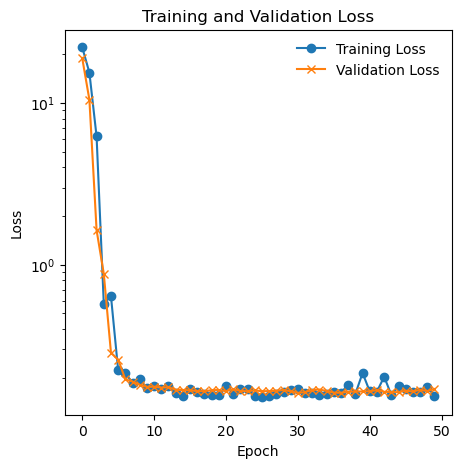

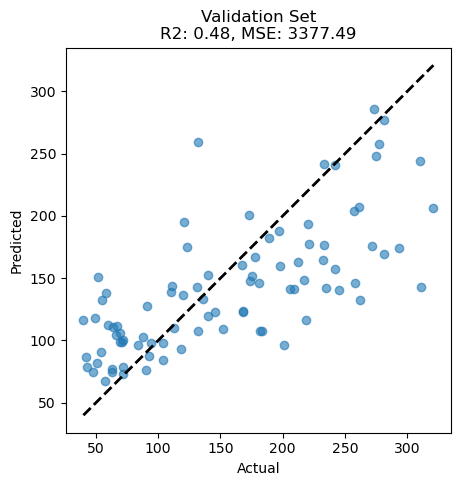

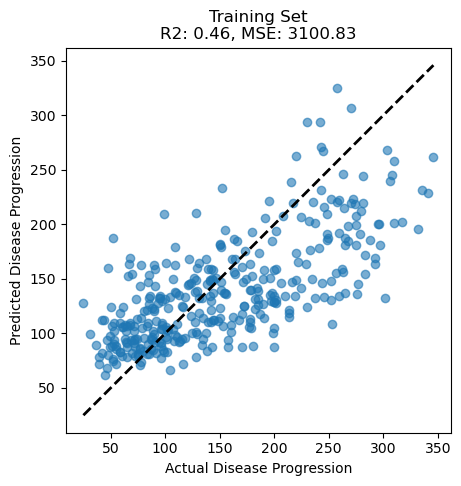

In [48]:
losses = utilities.extract_training_losses(trainer.metadata)
fig, ax = plots.plot_training_validation_loss(losses['avg_train_losses'], losses['avg_val_losses'])
ax.set_yscale("log")

y_val, y_hat_val = utilities.get_model_predictions(model, diabetes_dataset, train=False)
y_train, y_hat_train = utilities.get_model_predictions(model, diabetes_dataset, train=True)
fig, ax = plots.correlate_y_vs_yhat(np.exp(y_val), np.exp(y_hat_val), title="Validation Set")
fig, ax = plots.correlate_y_vs_yhat(np.exp(y_train), np.exp(y_hat_train), title="Training Set")
ax.set_xlabel("Actual Disease Progression")
ax.set_ylabel("Predicted Disease Progression")

In [49]:
k = 3
k_fold_datasets = []
k_fold_models = []
trainers = []

for n in range(k):
    network_architecture = [32, 8]
    model = modules.LinearReLUMLP(network_architecture, learning_rate=5e-3, weight_decay=5e-5)
    model.apply_initialization(torch.randn(1, len(diabetes_dataset.feature_names)))
    data = dataloader.KFoldDataSet.from_dataset(dataset=diabetes_dataset, k=k, n=n)

    trainer = Trainer(max_epochs=25, init_random=42)
    trainer.fit(model, data)

    k_fold_datasets.append(data)
    k_fold_models.append(model)
    trainers.append(trainer)

    

/Users/patrickrowe/miniconda3/envs/main/lib/python3.12/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Model running on cpu
Epoch 25/25: Train Loss: 0.1489, Val Loss: 0.18585
Model running on cpu
Epoch 25/25: Train Loss: 0.1651, Val Loss: 0.14966
Model running on cpu
Epoch 25/25: Train Loss: 0.1739, Val Loss: 0.15807


## Model Trained on cross-validation set 1/3

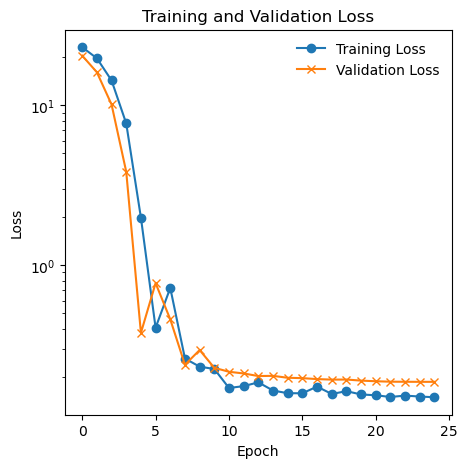

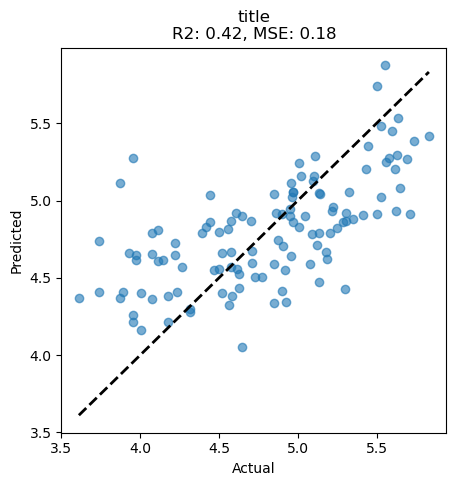

## Model Trained on cross-validation set 2/3

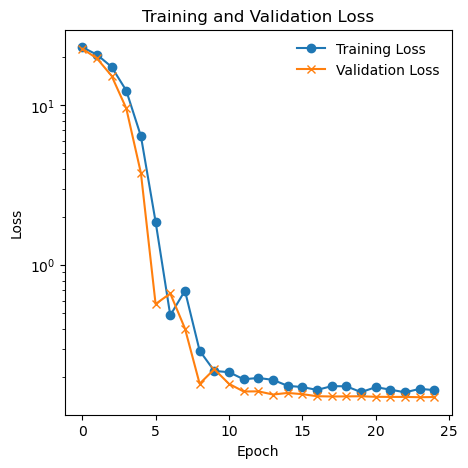

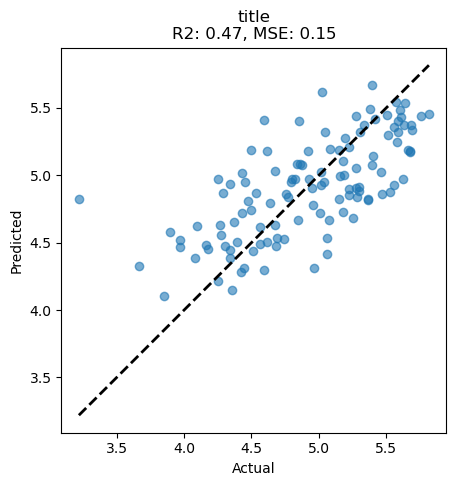

## Model Trained on cross-validation set 3/3

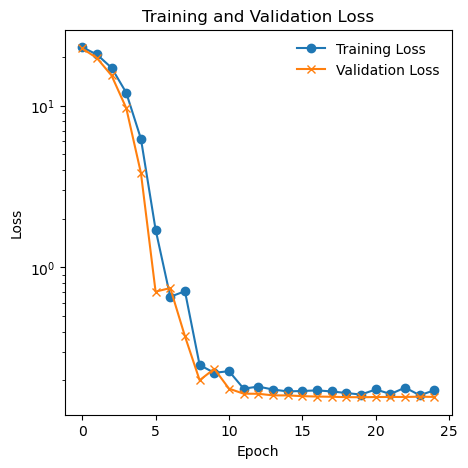

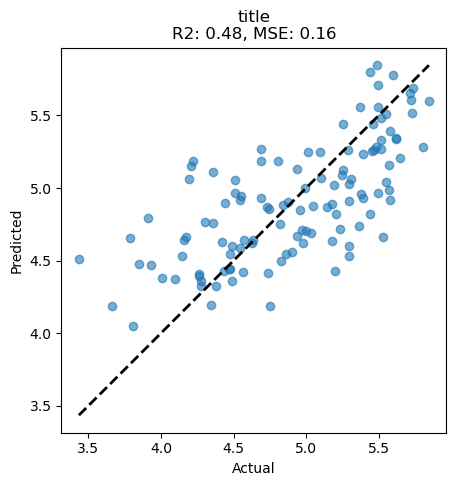

In [50]:
for i, trainer in enumerate(trainers):
    display(Markdown(f"## Model Trained on cross-validation set {i+1}/{k}"))

    losses = utilities.extract_training_losses(trainer.metadata)
    fig, ax = plots.plot_training_validation_loss(losses['avg_train_losses'], losses['avg_val_losses'])
    ax.set_yscale("log")
    y, y_hat = utilities.get_model_predictions(model, k_fold_datasets[i], train=False)
    fig, ax = plots.correlate_y_vs_yhat(y, y_hat, title="title")
    # ax.set_xlabel("Actual Price (USD)")
    # ax.set_ylabel("Predicted Price (USD)")
    plt.show()